<a href="https://colab.research.google.com/github/vanassap98/ONLINE_DS_THEBRIDGE_MOD1/blob/main/18_Practica_Obligatoria_CNN_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](attachment:image.png)

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
# === Librerías generales ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import gc
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# === Visualización y configuración ===
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)

# === Lectura de imágenes ===
from skimage.io import imread

# === Tensorflow y Keras ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Modelos preentrenados ===
from tensorflow.keras.applications import VGG19, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


In [2]:
# Verificación de GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [3]:
import kagglehub

# Descarga del dataset "Intel Image Classification"
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [4]:
# path descargado con kagglehub
ROOT_PATH = path

# Rutas a los datos de entrenamiento y test
TRAIN_PATH = ROOT_PATH + "/seg_train/seg_train/"
TEST_PATH  = ROOT_PATH + "/seg_test/seg_test/"

# Comprobamos qué clases hay en cada conjunto
print("Clases en entrenamiento:", os.listdir(TRAIN_PATH))
print("Clases en test:", os.listdir(TEST_PATH))

Clases en entrenamiento: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Clases en test: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


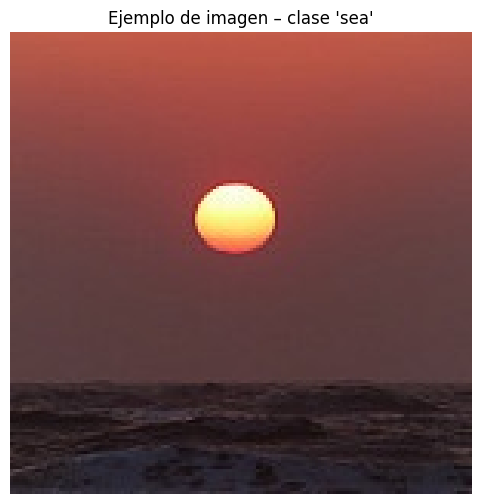

Forma de la imagen: (150, 150, 3)


In [5]:
# Leer una imagen de la clase "sea"
img = imread(TRAIN_PATH + "/sea/11321.jpg")

# Mostrar
plt.imshow(img)
plt.axis('off')
plt.title("Ejemplo de imagen – clase 'sea'")
plt.show()

print("Forma de la imagen:", img.shape)

In [6]:
# Parámetros globales de tamaño de imagen
IMG_WIDTH = IMG_HEIGHT = 75

In [11]:
def read_data(directorio, reshape_dim=(IMG_WIDTH, IMG_HEIGHT)):
    X = []
    y = []

    for folder in os.listdir(directorio):
        print(folder)
        folder_path = os.path.join(directorio, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                image = imread(os.path.join(directorio, folder, file))
                image = cv2.resize(image, reshape_dim)
                X.append(image)
                y.append(folder)

    return np.array(X), np.array(y)

In [12]:
def show_images_batch(paisajes, names=[], n_cols=5, size_scale=2):
    n_rows = (len(paisajes) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))

    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap="Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

    plt.tight_layout()
    plt.show()

In [13]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

mountain
street
buildings
sea
forest
glacier
mountain
street
buildings
sea
forest
glacier


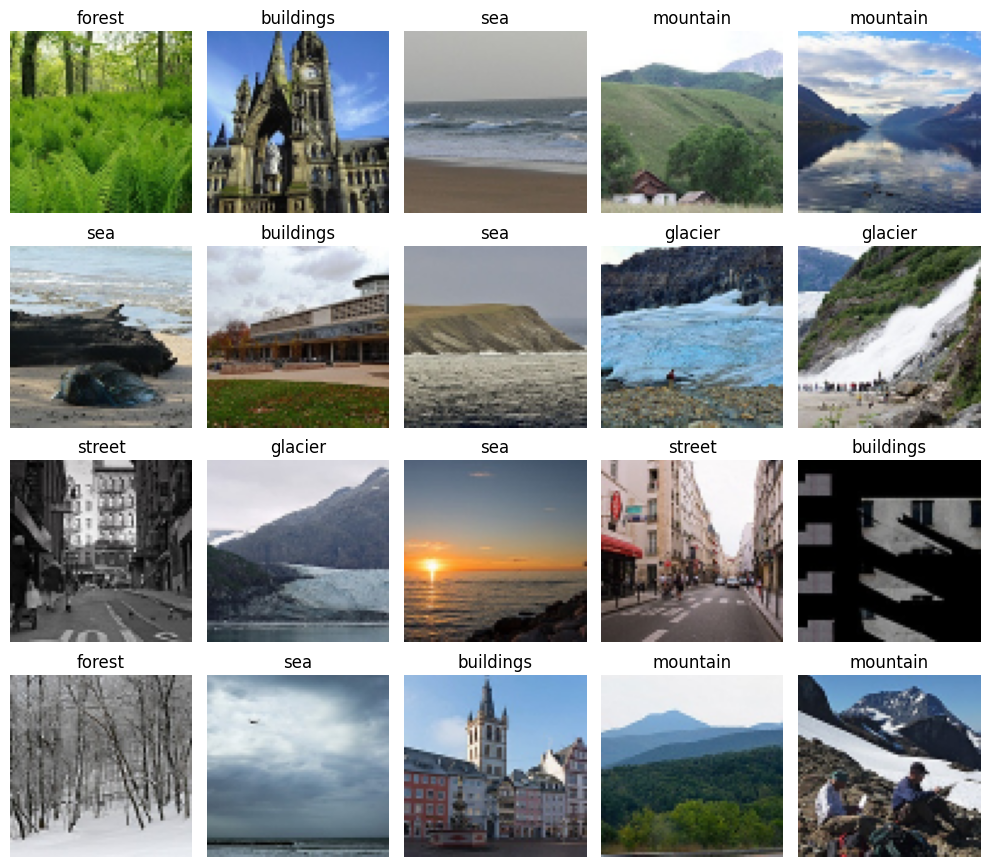

In [14]:
# Seleccionar 20 índices aleatorios del conjunto de entrenamiento
indices = np.random.randint(0, len(X_train), 20)

# Mostrar las imágenes seleccionadas y sus etiquetas
show_images_batch(X_train[indices], names=y_train[indices], n_cols=5)

In [ ]:
# Ver dimensiones de los conjuntos de datos
print("X_train shape:", X_train.shape)
print("X_train size:", X_train.size)
print("X_test shape:", X_test.shape)

In [15]:
# Escalado: normalizamos los valores de píxeles al rango [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
from keras.applications import InceptionV3

# Cargamos InceptionV3 sin la capa final (include_top=False)
test_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(75, 75, 3)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Ver forma esperada de entrada y salida
print("Input shape:", test_model.input)
print("Output shape:", test_model.output)

Input shape: <KerasTensor shape=(None, 75, 75, 3), dtype=float32, sparse=False, name=keras_tensor>
Output shape: <KerasTensor shape=(None, 1, 1, 2048), dtype=float32, sparse=False, name=keras_tensor_310>


In [18]:
# Eliminamos el modelo de prueba para liberar memoria
del test_model
gc.collect()

0

In [19]:
# Construcción del modelo para Transfer Learning
IMG_WIDTH = IMG_HEIGHT = 75  # asegúrate de que estas variables estén definidas antes

# Cargamos la base del modelo preentrenado
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
)

# Congelamos las capas convolucionales del modelo base
for layer in base_model.layers:
    layer.trainable = False

In [20]:
def prepare_model(base_model=base_model):
    """
    Añade una cabeza densa a un modelo preentrenado congelado y lo compila.
    """
    # Aplanado de la salida de InceptionV3
    x = keras.layers.Flatten()(base_model.output)

    # Capa oculta densa
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate=0.25)(x)

    # Capa de salida para 6 clases (con softmax)
    x = keras.layers.Dense(6, activation='softmax')(x)

    # Modelo completo
    model = keras.Model(base_model.input, x)

    # Compilación
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # usamos sparse porque las etiquetas son enteros
        metrics=['acc']
    )

    return model

In [21]:
model = prepare_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 37, 37,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 35, 35,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 35, 35,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 17, 17,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 17, 17,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 15, 15,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [22]:
instancias_train = len(X_train)  # Número total de imágenes de entrenamiento

# Comprobamos cómo varía el número de pasos por época según el batch size
for i in range(1, 5):
    batch_size = 32 * i
    steps = round(instancias_train * 0.8 / batch_size)
    print(f"Batch_size: {batch_size}, num_steps_per_epoch: {steps}")

Batch_size: 32, num_steps_per_epoch: 351
Batch_size: 64, num_steps_per_epoch: 175
Batch_size: 96, num_steps_per_epoch: 117
Batch_size: 128, num_steps_per_epoch: 88


In [23]:
# Convertimos las etiquetas a una Serie de pandas para trabajar con ellas
targets = pd.Series(y_train)

# Creamos un diccionario de clase → número
mapa = {tipo: indice for indice, tipo in enumerate(targets.unique())}
print(mapa)

{'mountain': 0, 'street': 1, 'buildings': 2, 'sea': 3, 'forest': 4, 'glacier': 5}


In [24]:
# Reemplazamos las etiquetas por sus equivalentes numéricos
y_train = np.array([mapa[clase] for clase in y_train])
y_test  = np.array([mapa[clase] for clase in y_test])

In [28]:
# Si ya tenemos etiquetas codificadas como enteros, simplemente las asignamos
y_train_num = y_train
y_test_num = y_test

# Barajamos los datos
from sklearn.utils import shuffle
X_train_s, y_train_s = shuffle(X_train, y_train_num)

In [29]:
from time import time

# Evaluamos distintos batch_size para estimar tiempos de entrenamiento
for batch_size in [32, 64, 96, 128]:
    t_zero = time()

    model = prepare_model()
    model.fit(
        X_train,
        y_train_num,
        batch_size=batch_size,
        validation_split=0.2,
        epochs=1,
        verbose=0
    )

    tiempo = round(time() - t_zero, 3)

    # Liberamos memoria tras cada prueba
    del model
    gc.collect()

    print(f"batch_size: {batch_size}, num_steps: {len(X_train) // batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")


batch_size: 32, num_steps: 438, tiempo 1 epoca: 50.559, tiempo 20 épocas: 1011.18
batch_size: 64, num_steps: 219, tiempo 1 epoca: 35.259, tiempo 20 épocas: 705.1800000000001
batch_size: 96, num_steps: 146, tiempo 1 epoca: 36.267, tiempo 20 épocas: 725.34
batch_size: 128, num_steps: 109, tiempo 1 epoca: 50.346, tiempo 20 épocas: 1006.92


In [30]:
batch_size = 128

# Definimos early stopping
earlyS = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Entrenamiento completo con control de tiempo
t_zero = time()

model = prepare_model()
history = model.fit(
    X_train_s,
    y_train_s,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=40,
    callbacks=[earlyS],
    verbose=1
)

tiempo = round(time() - t_zero, 3)
print(f"Tiempo total de entrenamiento: {tiempo} segundos")

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 232ms/step - acc: 0.6193 - loss: 1.0801 - val_acc: 0.7702 - val_loss: 0.6265
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.8242 - loss: 0.4792 - val_acc: 0.7766 - val_loss: 0.6040
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - acc: 0.8739 - loss: 0.3530 - val_acc: 0.7667 - val_loss: 0.6439
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - acc: 0.9164 - loss: 0.2525 - val_acc: 0.7781 - val_loss: 0.6457
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.9483 - loss: 0.1664 - val_acc: 0.7816 - val_loss: 0.6505
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9759 - loss: 0.1062 - val_acc: 0.7830 - val_loss: 0.7047
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9890 - loss: 0.0639 - val_acc: 0.7823 - val_loss: 0.7683
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - acc: 0.9958 - loss: 0.0361 - val_acc: 0.7745 - val_loss: 0.8288
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.99